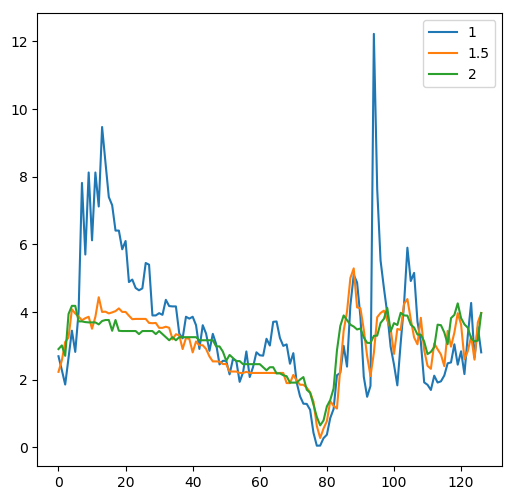

In [5]:
from urllib.request import urlretrieve
import os
import numpy as np
import tensorflow as tf
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cv2
from scipy import signal
from numpy import linalg as LA
from scipy import ndimage
import random
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


def load_img(img_path):
    # read img and fft 
    img   = cv2.imread(img_path,0)
    img   = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
    f_1   = np.fft.fft2(img)
    fshift_1 = np.fft.fftshift(f_1)
    magnitude_spectrum_1  = np.log(np.abs(fshift_1))
    
    magnitude_spectrum_1 = magnitude_spectrum_1.copy()
    magnitude_spectrum_1  = cv2.normalize(magnitude_spectrum_1,  magnitude_spectrum_1, 0, 255, cv2.NORM_MINMAX)
    #ret,magnitude_spectrum_1 = cv2.threshold(magnitude_spectrum_1,150,255,cv2.THRESH_BINARY) #--------------------------------------- 解掉註解能夠二值化
#     4-6沒有二值化 7-9有二值化(127) 10-12(200) 13-15(150)
    #plt.imshow(magnitude_spectrum_1,cmap='gray') #--------------------------------------- 解掉註解能夠看最後一張load 進來的圖長怎樣
    return magnitude_spectrum_1

def load_data():
    imgs   = {'rough1.0-1.5': [] , 'rough1.5-2.5': []}
    ra_info = {'rough1.0-1.5': [] , 'rough1.5-2.5': []}
    ra_dataframe  = pd.read_csv('./rough_data.csv', header=None)
    
    for k in imgs.keys():
        dir = './' + k + '/'
        for file in os.listdir(dir):
            
            if not file.lower().endswith('.jpg'):
                continue
            try:
                num,right  = file.split("_",1)
                dire,right = right.split(".",1)
                row        = 0
                col        = 0
                if dire == 'left':
                    col = 0
                else:
                    col = 1
                row = int(num) - 1
                ra_value = ra_dataframe.iloc[row,col]
                resized_img = load_img(os.path.join(dir, file))
            except OSError:
                continue
            imgs[k].append(resized_img)
            ra_info[k].append(ra_value)
    return ra_info,imgs        

def conv_img(img,filter_design):
    # apply convolve2d , return conv_array and std axis
    conv_array = signal.convolve2d(img, filter_design , mode='valid')
    x_axis_array,y_axis_array = np.where(conv_array > (np.mean(conv_array)+(np.max(conv_array)-np.mean(conv_array))/2))
    #(center_x,center_y) = ndimage.measurements.center_of_mass(conv_array)
    return conv_array,[np.std(x_axis_array),np.std(y_axis_array)]

def conv_iter(img_dic,filt):
    result_conv = {'rough1.0-1.5': [] , 'rough1.5-2.5': []}
    axis  = {'rough1.0-1.5': [] , 'rough1.5-2.5': []}
    for k in img_dic.keys():
        for img in img_dic[k]:
            conv_array,axis_value = conv_img(img ,filt)
            result_conv[k].append(conv_array)
            axis[k].append(axis_value)
    return result_conv,axis

def oppent_display(axes,axis,std_order):
    opponent_sum = 0
    # rough1.0-1.5
    mean_x = np.mean(np.array(axis['rough1.0-1.5'])[:,0])
    mean_y = np.mean(np.array(axis['rough1.0-1.5'])[:,1])
    # * 1 std
    width  = np.std(np.array(axis['rough1.0-1.5'])[:,0])*2 * std_order
    height = np.std(np.array(axis['rough1.0-1.5'])[:,1])*2 * std_order
    left_x = mean_x - width/2
    bottom_y = mean_y - height/2
    
    self_number = 0
    oppo_number = 0
    ac     = Rectangle((left_x, bottom_y), width, height,facecolor = 'None')
    
    for element in np.array(axis['rough1.0-1.5']):
        if ac.contains_point(element):
            self_number += 1
    
    for element in np.array(axis['rough1.5-2.5']):
        if ac.contains_point(element):
            oppo_number += 1
            
    opponent_sum += (oppo_number) / self_number
    
    re     = Rectangle((left_x, bottom_y), width, height,facecolor = 'None',edgecolor='red',linewidth = 1)
    
    # rough1.5-2.5
    mean_x = np.mean(np.array(axis['rough1.5-2.5'])[:,0])
    mean_y = np.mean(np.array(axis['rough1.5-2.5'])[:,1])
    # * 1 std
    width  = np.std(np.array(axis['rough1.5-2.5'])[:,0])*2 * std_order
    height = np.std(np.array(axis['rough1.5-2.5'])[:,1])*2 * std_order
    left_x = mean_x - width/2
    bottom_y = mean_y - height/2
    ac     = Rectangle((left_x, bottom_y), width, height,facecolor = 'None')
    
    self_number = 0
    oppo_number = 0
    
    for element in np.array(axis['rough1.0-1.5']):
        if ac.contains_point(element):
            oppo_number += 1
            
    for element in np.array(axis['rough1.5-2.5']):
        if ac.contains_point(element):
            self_number += 1
            
    opponent_sum += (oppo_number) / self_number
    
    re     = Rectangle((left_x, bottom_y), width, height,facecolor = 'None',edgecolor='blue',linewidth = 1)
    return opponent_sum

if __name__ == '__main__':
    color   = {'rough1.0-1.5': 'r' , 'rough1.5-2.5': 'b'}
    plt_store_x = {'rough1.0-1.5': [] , 'rough1.5-2.5': []}
    plt_store_y = {'rough1.0-1.5': [] , 'rough1.5-2.5': []}
    test_filter = [[0, 0, 0], [0, 0, 1], [1, 0, 1]]
    
    std_order_x = []
    std_order_list = [1,1.5,2]
    std_order_plot = {'1': [] , '1.5': [] , '2':[]}
    # define iterate number
    iteration_num = 127
    
    # load image and return spectrum
    ra_info,img_dic = load_data()
    
    fig, axes = plt.subplots(1, 1, figsize=(6, 6),dpi=100)
    
    
    for i in range(iteration_num):
        img_dic,axis = conv_iter(img_dic,test_filter)
        
        std_order_x.append(i)
        
        for std_order in  std_order_list:
            opponent_sum = oppent_display(axes,axis,std_order)
            std_order_plot[str(std_order)].append(opponent_sum)
    
    for k in std_order_plot.keys():
        axes.plot(std_order_x,std_order_plot[k],label=k)
    axes.legend()
    fig.show()
    df = pd.DataFrame({'1': std_order_plot['1'] ,'1.5' : std_order_plot['1.5'] ,'2': std_order_plot['2']})
    export_csv = df.to_csv (r'./std_order_dataframe.csv', index = None, header=True)